# Model related code
Made by: Tashyan Artyom, U2110268

### Imports and parameters

In [18]:
# Imports
import pickle
import re
import torch
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

from torch import tensor, optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.feature_extraction.text import CountVectorizer

In [627]:
# Parameters and constants
MAX_LEN = 10000
learning_rate = 0.001
decay_rate = 1e-3
epochs = 10
batch_size = 2048
hidden_size = 512
hidden_size_2 = 10
train_factor = 0.6
test_factor = 0.2
valid_factor = 0.2
fresh_start = False
train_model = True

nltk.download('stopwords')

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Selected device: {device}")

Selected device: cuda


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sqdar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data preparation

In [536]:
# Uploading our data from csv
df = pd.read_csv("./data/data.csv")
df["text"] = df["text"].fillna("")
df.head()

,Unnamed: 0,text,label
0,0,"Buck up, your troubles caused by small dimensi...",1
1,1,\nUpgrade your sex and pleasures with these te...,1
2,2,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1
3,3,Would anyone object to removing .so from this ...,0
4,4,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1


In [21]:
def preprocess_text(text: str) -> str:
    lower_text = text.lower()
    text_without_links = re.sub(r'http\S+|www\S+|https\S+', '', lower_text, flags=re.MULTILINE)
    plain_text = re.sub(r'[^a-zA-Z\s]', '', text_without_links)
    return plain_text

In [22]:
def tokenizer(text) -> list[str]:
    stemmer = PorterStemmer()
    tokens = re.findall(r'\b\w+\b', text)
    
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]
    
    tokens = [stemmer.stem(word) for word in tokens]
    return tokens

In [605]:
# Dataset
class EmailDataset(Dataset):
    def __init__(self, email_df, vectorizer):
        self.emails = email_df["text"]
        self.labels = tensor(email_df["label"], dtype=torch.long)
        self.vectorizer = vectorizer
        
        csr_matrix = self.vectorizer.transform(self.emails)
        coo_matrix = csr_matrix.tocoo()
        indices = tensor([coo_matrix.row, coo_matrix.col])
        values = tensor(coo_matrix.data, dtype=torch.float32)
        self.vectorized_emails = torch.sparse_coo_tensor(indices, values, torch.Size(coo_matrix.shape)).to_dense()
        
    def __getitem__(self, index):
        email_vector = self.vectorized_emails[index]
        label = self.labels[index]
        return email_vector.to(device), label.to(device)
    
    def __len__(self):
        return len(self.emails)

In [24]:
# Vectorizer to convert texts of emails to vectors
if fresh_start:
    vectorizer = CountVectorizer(
        max_features=MAX_LEN,
        tokenizer=tokenizer,
        preprocessor=preprocess_text
    )
    vectorizer.fit(df["text"])
    
    with open("./vocab.pkl", "wb") as file:
        pickle.dump(vectorizer, file)
else:
    with open("./vocab.pkl", "rb") as file:
        vectorizer = pickle.load(file)

In [537]:
vectorizer.vocabulary_["cum"]

np.int64(2020)

In [26]:
if fresh_start:
    ds = EmailDataset(df, vectorizer)
    
    with open("./train_data.pkl", "wb") as file:
        pickle.dump(ds, file)
else:
    with open("./train_data.pkl", "rb") as file:
        ds = pickle.load(file)

In [606]:
train_ds, valid_ds, test_ds = random_split(ds, [train_factor, valid_factor, test_factor])

In [620]:
# Dataloaders
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

### Model and training loop definition

In [621]:
# Function to assess accuracy of the model
@torch.no_grad
def accuracy(predictions: tensor, actuals: tensor) -> float:
    _, preds =torch.max(predictions, 1)
    accuracy = torch.sum(preds == actuals.view(-1))/predictions.shape[0]
    return accuracy.item()

In [639]:
# Model
class PhishingDetectorModel(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.layers = nn.ModuleList([
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size_2),
            nn.ReLU(),
            nn.Linear(hidden_size_2, output_size)
        ])
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [640]:
model = PhishingDetectorModel(
    input_size=MAX_LEN,
    hidden_size=hidden_size, 
    output_size=2
).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay_rate)
class_weights = torch.tensor([0.6, 0.4]).to(device)
loss_function = nn.CrossEntropyLoss()

In [641]:
# Training loop
def fit(epochs, model, train_dl, valid_dl, loss_function, optimizer, t_losses, v_losses, t_accuracies, v_accuracies):
    for epoch in range(epochs):
        model.train()
        total_loss, total_acc, count = 0., 0., 0.
        for x_batch, y_batch in train_dl:
            optimizer.zero_grad()
            predictions = model(x_batch)
            loss = loss_function(predictions, y_batch.view(-1))
            batch_len = len(x_batch)
            count += batch_len
            total_loss += loss.item() * batch_len
            acc = accuracy(predictions, y_batch.view(-1))
            total_acc += acc * batch_len
            loss.backward()
            optimizer.step()
        t_losses.append(total_loss / count)
        t_accuracies.append(total_acc / count)
        
        model.eval()
        with torch.no_grad():
            total_loss, total_acc, count = 0., 0., 0.
            for x_batch, y_batch in valid_dl:
                predictions = model(x_batch)
                loss = loss_function(predictions, y_batch.view(-1))
                batch_len = len(x_batch)
                count += batch_len
                total_loss += loss.item() * batch_len
                acc = accuracy(predictions, y_batch.view(-1))
                total_acc += acc * batch_len
            v_losses.append(total_loss / count)
            v_accuracies.append(total_acc / count)
        
        print(f"Epoch: {epoch}, Loss: {total_loss / count}, Accuracy: {total_acc / count}")
        

In [642]:
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

if train_model:
    fit(
        epochs=epochs,
        model=model,
        loss_function=loss_function,
        optimizer=optimizer,
        train_dl=train_dl,
        valid_dl=valid_dl,
        t_losses=train_losses,  
        v_losses=valid_losses,
        t_accuracies=train_accuracies,
        v_accuracies=valid_accuracies,
    )   
else:
    with open("./model.pkl") as file:
        model = pickle.load(file)

Epoch: 0, Loss: 0.15732023011586663, Accuracy: 0.9447982290098417
Epoch: 1, Loss: 0.15507415904922459, Accuracy: 0.9498382426091725
Epoch: 2, Loss: 0.13198207398451878, Accuracy: 0.9563425846447353
Epoch: 3, Loss: 0.11664737728848563, Accuracy: 0.9621317898539045
Epoch: 4, Loss: 0.10697855535401775, Accuracy: 0.966184233480431
Epoch: 5, Loss: 0.10909105220366515, Accuracy: 0.9673080203014766
Epoch: 6, Loss: 0.09373207884611841, Accuracy: 0.9696237018622715
Epoch: 7, Loss: 0.09142247884171634, Accuracy: 0.9693512679242446
Epoch: 8, Loss: 0.09284032495651459, Accuracy: 0.9692491056179038
Epoch: 9, Loss: 0.08393978986812373, Accuracy: 0.9707815432028898


In [633]:
# Save model
if train_model:
    with open("./model.pkl", "wb") as file:
        pickle.dump(model, file)

### Data vizualization

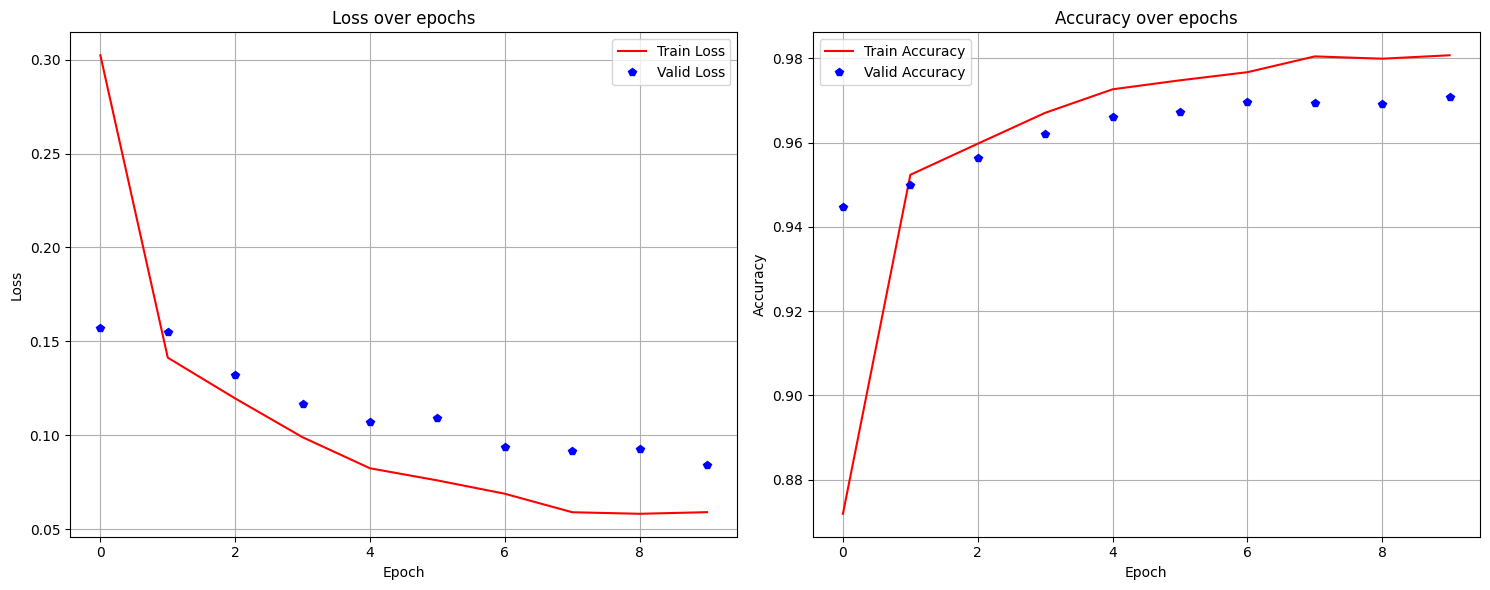

In [643]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ax[0].plot(train_losses, "r", label="Train Loss")
ax[0].plot(valid_losses, "bp", label="Valid Loss")
ax[0].set_title("Loss over epochs")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[0].grid()
ax[0].set_ylabel("Loss")

ax[1].plot(train_accuracies, "r", label="Train Accuracy")
ax[1].plot(valid_accuracies, "bp", label="Valid Accuracy")
ax[1].set_title("Accuracy over epochs")
ax[1].set_xlabel("Epoch")
ax[1].legend()
ax[1].grid()
ax[1].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()

### Interface to call the model prediction

In [644]:
def predict_email(email, model, vectorizer, device, top_n=5):
    model.eval()
    
    email_csrmatrix = vectorizer.transform([email])
    email_coomatrix = email_csrmatrix.tocoo()
    indices = tensor([email_coomatrix.row, email_coomatrix.col]).to(device)
    values = tensor(email_coomatrix.data, dtype=torch.float32).to(device)
    email_tensor = torch.sparse_coo_tensor(indices, values, torch.Size(email_coomatrix.shape)).to_dense().to(device)
    
    with torch.no_grad():
        outputs = model(email_tensor)
        _, prediction = torch.max(outputs, 1)
        
        first_layer_weights = model.layers[0].weight.data.cpu().numpy()
        suspicious_weights = first_layer_weights[1]
        
        word_importance = email_tensor[0].cpu() * suspicious_weights
        important_words_indices = np.argsort(word_importance)[-top_n:]
        
        important_words = [vectorizer.get_feature_names_out()[i] for i in important_words_indices]
        important_scores = [word_importance[i] for i in important_words_indices]
        
        important_scores = tensor(important_scores).softmax(dim=0)
        important_scores = [score * 100 for score in important_scores]
    
    return prediction.item(), torch.softmax(outputs, dim=1).cpu().numpy(), list(zip(important_words, important_scores))

In [646]:
sus_mail = """Dear Customer,

To ensure the continued security of your account, we need you to update your account details. Please verify your information by October 5th, 2024 to avoid any disruption in service.

Click here to update your account:
Update Account

Thank you for helping us keep your account safe.

Best regards,
Customer Support
[Company Name]"""

ok_mail = """Hey Robert,

I hope you’re doing well! It’s been a while, and I just wanted to catch up and see how things are going on your end. How’s work/life/your latest project coming along?

I’d love to hear from you when you get a chance. Maybe we could grab a coffee or have a virtual chat sometime soon?

Take care, and hope to hear from you soon!

Warm regards,
William
[Your Company/Position (optional)]"""
 
sus, confidency, words = predict_email(ok_mail, model, vectorizer, device, top_n=10)

print(f"Sus: {sus}, Confidence: {confidency.max() * 100:.2f}, Words: {words}")

Sus: 0, Confidence: 99.11, Words: [('well', tensor(9.9801)), ('thing', tensor(9.9819)), ('come', tensor(9.9844)), ('regard', tensor(9.9850)), ('want', tensor(9.9879)), ('go', tensor(9.9881)), ('take', tensor(10.0042)), ('hope', tensor(10.0080)), ('see', tensor(10.0353)), ('get', tensor(10.0451))]


C:\Users\sqdar\AppData\Local\Temp\ipykernel_4100\1932624220.py:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  word_importance = email_tensor[0].cpu() * suspicious_weights


In [393]:
# Validate on test data set
losses, accuracies = [], []
total_loss, total_acc, count = 0., 0., 0.
 
model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_dl:
        predictions = model(x_batch)
        loss = loss_function(predictions, y_batch.view(-1))
        count += len(x_batch)
        total_loss += loss.item()
        acc = accuracy(predictions, y_batch)
        total_acc += acc * len(x_batch)
    losses.append(total_loss / count)
    accuracies.append(total_acc / count)
    
print(f"Loss: {total_loss / count}, Accuracy: {total_acc / count}")

Loss: 6.564357911082189e-05, Accuracy: 0.9707124369327289
